# Continuous Optimization Problem
### By Moritz Hildemann and Judith Verstegen, 2023

The following tutorial has the intention to give you a first idea on how to define a continuous (spatial) problem and how optimization algorithms work to solve the particular problem.

#Most important terms

##Problem
An optimization problem is defined as the minimization or maximization of one or several objective functions that can be subject to none, one, or several constraints being used to validate the feasibility of solutions (Chiandussi et al, 2012). Solutions are found by changing the decision variables.

##Decision variable(s)
A decision (or control) variable is a variable that can be changed to alter the solution and thereby the optimality of the modelled problem. It represents the part of the system that can be controlled (e.g. a policy variable).

##Solution
Every solution to a the problem is one (spatial) configuration defined by the value(s) of the decision variable(s).

##Objective(s)
Objectives represent the wishes of the decision maker(s), i.e. what should be maximized or minimized in order to have an 'optimal' solution.

##Objective function(s)
An objective function is the (mathematical) function to compute the objective value on the basis of the solution. That means that the solution is always input to the objective function.

##Constraint(s)
Constraints are set to limit the values the decision variable can take, or are used to filter out solutions that are infeasible (despite having valid decision variable values). 

#Problem: Finding the peak of a mountain

So, in general, optimization algorithms aim to find the maximum or minimum of one objective function, or the multiple maxima/minima of a combination of conflicting objective functions. We start with a simple and easy to picture optimization problem with one objective and two decision variables: a hiker wants to find the top (**maximum**) of the mountain (described by an **objective function**). She starts at the parking lot at the bottom of the mountain and can change her location (x and y coordinate, the **two decision variables**) by walking. She should not wander off the map (**constraints** in possible values of x and y).

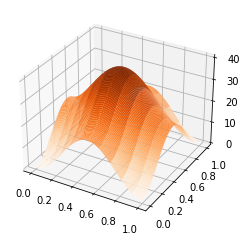

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy
import heapq

# Define a map for plotting the mountain and the position of the hiker
# Map coordinates range between 0 and 1 for both x and y
X = np.linspace(0, 1, 100)     
Y = np.linspace(0, 1, 100)     
X, Y = np.meshgrid(X, Y) 

# Use the rastrigin function to simulate the mountain
# Note that it will be our objective to maximize this function,
# Since the hiker aims to reach the top
Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
  (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20

# Create a matplotlib figure and plot the mountain
fig = plt.figure() 
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=10,
  cmap=cm.Oranges, linewidth=0.08,
  antialiased=True)    

plt.show()

In [9]:
# For the position of the hiker on the mountain (x,y,z) we create a class Point
class Point:
  def __init__(self, x,y):
        self.x = x
        self.y = y
        # Get the corresponding elevation from the rastrigin function
        self.z = (self.x**2 - 10 * np.cos(2 * np.pi * self.x)) + (self.y**2 - 10 * np.cos(2 * np.pi * self.y)) + 20
      

In [10]:
# Plot function for the mountain 
def plot_mountain(fig,X,Y):
  ax = fig.add_subplot(projection='3d')
  ax.plot_surface(X, Y, Z, rstride=1, cstride=10,
    cmap=cm.Oranges, linewidth=0.08, alpha=0.4, 
    antialiased=True)
  return ax

# Plot function for the position of the hiker,
# where p is a Point instance
def plot_position(ax, p, z_offset=2, color='b', size = 40):
  # Offset the point to make sure it is visible
  ax.scatter(p.x, p.y, p.z + z_offset, marker='o', s=size, c= color, edgecolors='black',linewidths=0.2)
  return ax

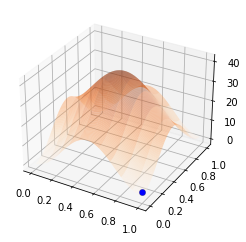

In [11]:
# Let's test the class and functions defined above
# Define a starting point of the hike
p_start = Point(1, 0)

# Set up an empty plot
fig = plt.figure()
# Produce the mountain plot
ax = plot_mountain(fig,X,Y)
# Plot the hiker's position
plot_position(ax, p_start)
# Show the plot
plt.show()

#Problem definition
Now, we have a landscape and a starting point of the hike. However, we still need to formulate the problem. Furthermore, we need the objective function to quantify the quality of potential solutions to the problem. 

In [12]:
# To do that, we first create a class to formalize solutions 
# and make sure we can keep track of them by numbering them
class Solution: 
    _id = 0
    
    def __init__(self, representation):
        self._solution_id = Solution._id
        Solution._id += 1
        # The representation is what the solution looks like
        # In spatial problems, this is normally the spatial representation,
        # for example a raster, a line, or a point
        # The representation will be input to the objective function
        self.representation = representation

    def verbose(self, print_representation=True):       
        print("Solution ID: %d\nFitness: %.2f\nIs admissible? %s" %
              (self._solution_id, self.fitness, self.valid))

In [13]:
# The following class is an example for a very generic problem
# We'll use it as our superclass
class Problem:
    def __init__(self, search_space, objective_function, minimization):
        self.search_space = search_space        
        self.objective_function = objective_function
        self.minimization = minimization
      
    def validate(self, solution):
      pass
    def evaluate(self, solution):
      pass

In [14]:
# Now, we use the same class structure to define our own hiking problem
class ContinuousProblem(Problem):
  
    def __init__(self, search_space, objective_function, minimization=False):
        Problem.__init__(self, search_space, objective_function, minimization)

    def evaluate(self, solution):
      # The validation process evaluates the objective function
      # Thereby, it determines the fitness of the solution
      point = solution.representation

      # The fitness is determined only when the solution is valid 
      # i.e. when it meets the contraint(s)
      solution.valid = self.validate(point)

      if solution.valid:
        solution.fitness = self.objective_function(point)
      else:
        # If the solution is invalid, give it a very high (when minimizing)
        # or very low (when maximizing) fitness value to indicate that
        # it is not good
        if self.minimization:
          solution.fitness = np.iinfo(np.int32).max
        else:
          solution.fitness = 0

    def validate(self, point):
      # The validation process determines whether a solution is a feasible  
      validity=True
      # constraint: hiker should remain on the map
      # check whether the x position is within the defined mountain region
      if point.x < self.search_space[0][0] or point.x > self.search_space[0][1]:
        validity=False
      # constraint: hiker should remain on the map
      # check whether the y position is within the defined mountain region
      if point.y < self.search_space[1][0] or point.y > self.search_space[1][1]:
          validity=False
      return validity


In [15]:
# The objective function to retrieve the fitness of solutions is still missing
# Here, it is just the z-value of the position, obtainable from the Point object
def get_elevation(point):
  return point.z

In [16]:
# Let's create the problem instance!
mountain_boundary=[[0,1],[0,1]]
hiking_problem = ContinuousProblem(search_space=mountain_boundary, \
                                   objective_function = get_elevation)



---


*Poll question: What might be the search space in a real world example?*

---



Now, we can test our problem with an example solution (a point, value for the decision variables x and y). 

Start position
Solution ID: 0
Fitness: 1.00
Is admissible? True

Test position
Solution ID: 1
Fitness: 31.63
Is admissible? True


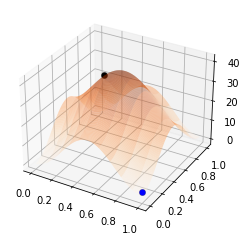

In [17]:
# Evaluate the starting position of the hiker
start_solution = Solution(representation=p_start)
hiking_problem.evaluate(start_solution)
print("Start position")
start_solution.verbose()

# Evaluate an exemplary solution with a position at  x = 0.3 and y = 0.3
test_solution = Solution(representation=Point(0.3,0.6))
hiking_problem.evaluate(test_solution)
print("\nTest position")
test_solution.verbose()

# Set up a new empty plot
fig = plt.figure()
# Produce the mountain
ax = plot_mountain(fig,X,Y)
# Plot the starting position of the hiker
ax = plot_position(ax, start_solution.representation)
# Plot the test solution position of the hiker
ax = plot_position(ax, test_solution.representation, color = 'black' )
# Show the figure
plt.show()

# Search algorithms

We would like to test multiple solutions in order to find the best one. We can do that, for example, manually, as we did above, or brute force, by writing a loop over all possible combinations or valid x and y coordinates. 

For this simple problem and small study area that may work. However, usually spatial problems are large in spatial extent, in complexity, and/or in number of objectives. Therefore, heuristics have been developed to go through the search space in a 'smart' way, to find near-optimal solutions in a feasible amount of time. 

Let's implement some of these algorithms, and use them on our simple problem. 

In [18]:
# Comparable to the general Problem class, 
# we define a general Search Algorithm class first, as our superclass.

class SearchAlgorithm:
    def __init__(self, problem_instance):
      self.problem_instance = problem_instance
 
    def initialize(self):
      pass
    
    def search(self, n_iterations, report=False):
      pass

    def get_best(self, candidate_a, candidate_b):
      # What is good or bad depends on whether we want to maximize or minimize
      if self.problem_instance.minimization:
        # For minimization, lower objective values are better
        if candidate_a.fitness >= candidate_b.fitness:
          return candidate_b
        else:
          return candidate_a
      else:
        # For maximization, higher objective values are better
        if candidate_a.fitness <= candidate_b.fitness:
          return candidate_b
        else:
          return candidate_a
    
    # We define reporting functions
    # They are not a requirement, but convenient for understanding and debugging
    def verbose_reporter(self):
      print("Best solution overall:")
      self.best_solution.verbose()

    def verbose_reporter_inner(self, solution, iteration):
      print("> > > Current best solution at iteration %d:" % iteration)
      solution.verbose()



## Random search

The first algorithm you will learn about is the random search. All heuristic search functions contain elements of randomness. In general, advanced search algorithms have the goal of outperforming the random search. Therefore, random search is a good starting point to learn how a search algorithm works.

In [19]:
# We define a function to help us simulate random walk
def random_neighbor_position(random_state, current_position, max_stepsize):
    
  def positive_or_negative():
    if random_state.random() < 0.5:
      return 1
    else:
      return -1

  current_x = current_position.x
  current_y = current_position.y

  # Find a neighboring x,y position to move towards
  random_neighbor_x = current_x + (positive_or_negative() * \
                                   (random_state.random() * max_stepsize))
  random_neighbor_y = current_y + (positive_or_negative() * \
                                   (random_state.random() * max_stepsize))
  return Point(random_neighbor_x, random_neighbor_y)

# And a class for the random search search algorithm
class RandomSearch(SearchAlgorithm):
  def __init__(self, problem_instance, random_state, initial_solution, 
               neighborhood_function = random_neighbor_position, 
               max_stepsize = 0.01):
    SearchAlgorithm.__init__(self, problem_instance)
    self.random_state = random_state
    # When creating the object, the best solution is the inital one
    self.best_solution = initial_solution
    self.neighborhood_function = neighborhood_function
    self.max_stepsize = max_stepsize
    self.problem_instance.evaluate(self.best_solution)
      
  def search(self, n_iterations, report=False):
    all_solutions = []
    i = self.best_solution

    # Perform random search for a predefined number of iterations
    for iteration in range(n_iterations):
      j = self.generate_new_position(i.representation)
      i = self.get_best(i, j)
      all_solutions.append(i)

      if report:
        self.verbose_reporter_inner(i, iteration)

    self.best_solution=i

    return all_solutions

  def generate_new_position(self, current_position):
    random_new_position = self.neighborhood_function(self.random_state, current_position = current_position, 
                                                     max_stepsize = self.max_stepsize)
    random_new_solution = Solution(random_new_position)
    self.problem_instance.evaluate(random_new_solution)
    return random_new_solution

In the next step, we define a pseudo random state.

---


*Poll question: What might be the reason to generate a random state with a pseudo-random state generator?*

---

In [20]:
# Creates a pseudo random number generator
def get_random_state(seed):
  return np.random.RandomState(seed)
# Setup random state
seed=1
random_state = get_random_state(seed)
# Test the generator
print(random_state.random())
print(random_state.random())

0.417022004702574
0.7203244934421581


Now, we can create a RandomSearch instance and start the search for optimal solutions

In [88]:
# Perform Random Search
start_solution = Solution(p_start)
hiking_problem.evaluate(start_solution)

rs = RandomSearch(hiking_problem, random_state, \
                  initial_solution = start_solution)

random_search_solutions = rs.search(n_iterations=400, report=False)
rs.verbose_reporter()

Best solution overall:
Solution ID: 106508
Fitness: 40.50
Is admissible? True


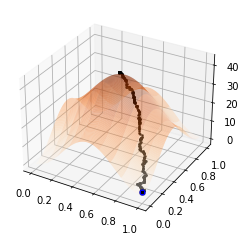

In [23]:
#set up an empty plot
fig = plt.figure()
# produce the mountain plot
ax = plot_mountain(fig,X,Y)
#produce the hike position plot
ax = plot_position(ax, p_start)
for i in range(len(random_search_solutions)):
  ax = plot_position(ax, random_search_solutions[i].representation, \
                     color = 'black', size = 5 )
#show the plots
plt.show()

You can run the same search with another seed and compare the results to see how different the optimum can be as well as the 'route' towards the optimum.

## Simulated Annealing

Annealing is a procedure that defines the optimal molecular arrangements of metal particles where the potential energy of the mass is minimized. The metal cools gradually after being subjected to high heat; the lower the temperature becomes, the less the particles can move, so the arrangement gradually stabilizes.

The Simulated Annealing (SA) algorithm adopts an iterative movement according to the variable temperature parameter which imitates the annealing transaction of the metals (Eren et al. 2017). Please see the figure below for a conceptual overview of SA.

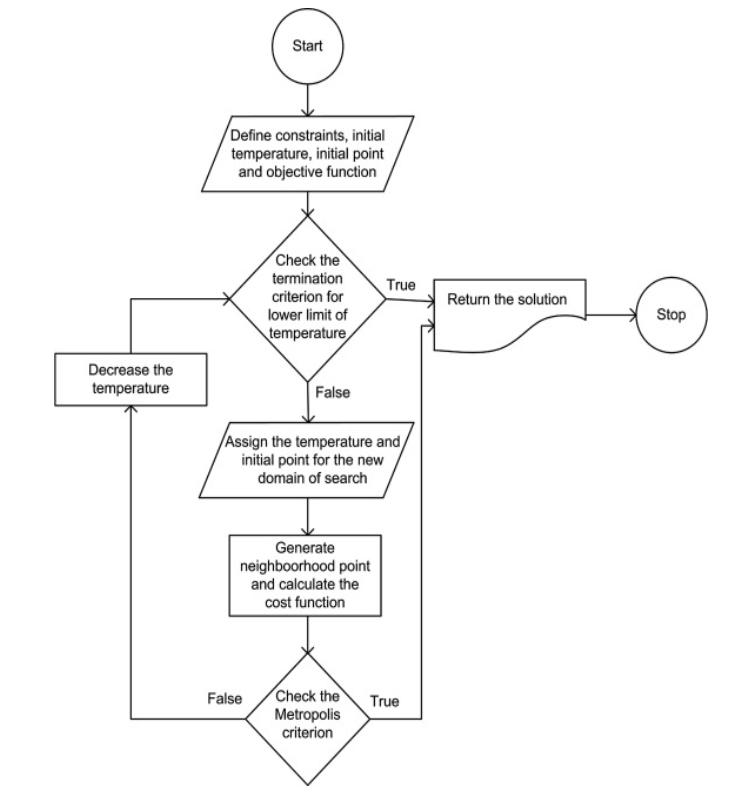

Again, we define a Python class. This one is based on Random Search.

In [26]:
import math

class Annealing(RandomSearch):
  def __init__(self, problem_instance, random_state, initial_solution,
               neighborhood_function = random_neighbor_position, 
               max_stepsize = 0.01, initial_temperature = 1, alpha = 0.01):
    RandomSearch.__init__(self, problem_instance, random_state,initial_solution,
                          neighborhood_function, max_stepsize)
    # The two parameters specific to SA
    self.initial_temperature = initial_temperature
    self.alpha = alpha
    
  def search(self, n_iterations, report=False):

    all_solutions = []
    current_temperature = self.initial_temperature
    i = self.best_solution

    for iteration in range(n_iterations):
      # Same as for random search
      j = self.generate_new_position(i.representation)
      # But now, the acceptance of the new solution depends on the temperature
      i = self.get_p_best(i, j, current_temperature)
      all_solutions.append(i)

      if report:
        self.verbose_reporter_inner(i, iteration)
      
      if current_temperature>=0.01:
        current_temperature -= self.alpha

    self.best_solution=i

    return all_solutions

  def get_p_best(self, candidate_a, candidate_b, actual_c):

    if candidate_b.valid:
      if self.problem_instance.minimization:
        # If the new solution is better we accept it
        if candidate_b.fitness <= candidate_a.fitness:
          solution = candidate_b
        # If the new solution is worse we accept it with a certain probability
        # Where the probability becomes lower with lower temperatures
        elif self.random_state.uniform(0, 1) < \
        (math.exp((candidate_b.fitness - candidate_a.fitness)) / actual_c):
          solution = candidate_b
        else:
          solution = candidate_a
      else:
        # Maximization, all the same, but the other way around
        # if the new solution is better we accept it
        if candidate_b.fitness >= candidate_a.fitness:
          solution = candidate_b
        # If the new solution is worse we accept it with a certain probability
        # Where the probability becomes lower with lower temperatures
        elif self.random_state.uniform(0, 1) < \
        (math.exp((candidate_b.fitness - candidate_a.fitness)) / actual_c):
          solution = candidate_b
        else:
          solution = candidate_a
    else:
      # If b is invalid, we take a
      solution = candidate_a
    
    return solution
      
  def generate_new_position(self, current_position):
    random_new_position = self.neighborhood_function(self.random_state, \
                                          current_position = current_position, 
                                          max_stepsize = self.max_stepsize)
    random_new_solution = Solution(random_new_position)
    self.problem_instance.evaluate(random_new_solution)
    return random_new_solution

In [27]:
random_state = get_random_state(20)
sa = Annealing(problem_instance = hiking_problem, random_state = random_state,
               initial_solution = start_solution, initial_temperature = 50)
#problem_instance, random_state, initial_solution

simulated_annealing_solutions = sa.search(n_iterations=400, report=False)
sa.verbose_reporter()

Best solution overall:
Solution ID: 1191
Fitness: 40.50
Is admissible? True


## Comparison between random search and simulated annealing

Let's compare the paths toward the optimum that the two search algorithms, Random Search and Simulated Annealing, took.

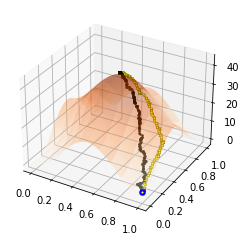

In [29]:
# Set up an empty plot
fig = plt.figure()
# Produce the mountain plot
ax = plot_mountain(fig,X,Y)
# Plot all positions of the hiker for both search algorithms
ax = plot_position(ax, p_start)
for i in range(len(random_search_solutions)):
  ax = plot_position(ax, random_search_solutions[i].representation, color = 'black', size = 5 )
for i in range(len(simulated_annealing_solutions)):
  ax = plot_position(ax, simulated_annealing_solutions[i].representation, color = 'yellow', size = 5 )
# Show the plot
plt.show()

What if we make the problem more difficult? We'll create a mountain area instead of a single mountain, where the highest mountain can be found in the corner of the area with the highest x and y coordinates. This means that the search algoritm has to pass through valleys before reaching a higher mountain.

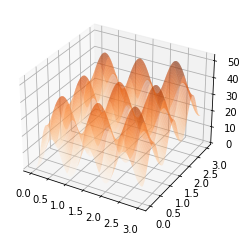

In [32]:
X = np.linspace(0, 3, 100)     
Y = np.linspace(0, 3, 100)     
X, Y = np.meshgrid(X, Y) 

mountain_boundary=[[0,3],[0,3]]
complex_hiking_problem = ContinuousProblem(search_space=mountain_boundary, \
                                           objective_function = get_elevation)

# Again, we use the rastrigin function to simulate the mountains
Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
  (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20
fig = plt.figure()
# Produce the mountain plot
ax = plot_mountain(fig,X,Y)
plt.show()

In [77]:
# Define the starting point again.
# Note that the map is larger, x and y can now vary between 0 and 3.
p_start = Point(0, 1)
# Perform Random Search on the complex problem
start_solution = Solution(p_start)
complex_hiking_problem.evaluate(start_solution)

rs = RandomSearch(complex_hiking_problem, random_state, max_stepsize= 0.2,\
                  initial_solution = start_solution)

complex_random_search_solutions = rs.search(n_iterations=2000, report=False)
rs.verbose_reporter()

Best solution overall:
Solution ID: 102359
Fitness: 40.50
Is admissible? True


In [78]:
# Perform Simulated Annealing on the complex problem
sa = Annealing(problem_instance = complex_hiking_problem,max_stepsize= 0.2, \
               random_state = random_state,
               initial_solution = start_solution, initial_temperature = 100, \
               alpha = 0.2)

complex_simulated_annealing_solutions = sa.search(n_iterations=2000, report=False)
sa.verbose_reporter()

Best solution overall:
Solution ID: 105194
Fitness: 42.51
Is admissible? True


Let's compare the optima and the paths toward the optimum for this more complex problem. Note that we have used a larger step size for the larger area. This influences the comparison (try it!).

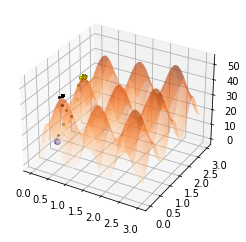

In [79]:
#set up an empty plot
fig = plt.figure()
# produce the mountain plot
ax = plot_mountain(fig,X,Y)
#produce the hike position plot
ax = plot_position(ax, p_start)
for i in range(len(complex_random_search_solutions)):
  ax = plot_position(ax, complex_random_search_solutions[i].representation, \
                     color = 'black', size = 5)
for i in range(len(complex_simulated_annealing_solutions)):
  ax = plot_position(ax, complex_simulated_annealing_solutions[i].representation, \
                     color = 'yellow', size = 5)
#show the plots
plt.show()

## Genetic Algorihms

The third search algorithm introduced here is a genetic algorithm (GA). First, we need to define some help functions. These are determining the way solutions evolve: How solutions are selected for reproduction, how the genes of parent solutions are recombined into chilren, and how the genes of the children are mutated.

In [82]:
def select_best_from_parents_and_children(parent_generation, child_generation):
  # In a GA, we do not keep a single best solution in memory
  # But we always have a population of solutions active
  # We create an array to story them
  combined_population = np.hstack((parent_generation, child_generation))
  objective_values_parents = [p.fitness for p in parent_generation]
  objective_values_children = [c.fitness for c in child_generation]
  all_objective_values = np.array(objective_values_parents + \
                                  objective_values_children)
  # Sort by the objective values 
  better_half = np.array(heapq.nlargest(parent_generation.shape[0], \
                                        enumerate(all_objective_values), \
                                        key=lambda x: x[1]), \
                         dtype=np.dtype(np.int32))
  # And get the ids of the better half
  survival_ids = better_half[:,0]
  return combined_population[survival_ids]

def tournament_selection(population, minimization, random_state, \
                         selection_pressure = 0.1):
  # Compute the tournament size
  # Default is 10% of the population size
  tournament_pool_size = int(len(population) * selection_pressure)
  # Select solutions for the tournament
  tournament_pool = random_state.choice(population, size=tournament_pool_size, \
                                        replace=False)
  # Set initial winner (does not matter which one)
  tournament_winner = tournament_pool[0]

  # Compare the fitness of all solutions in the tournament
  # To find the best one
  if minimization:
    for solution in tournament_pool:
      if solution.fitness < tournament_winner.rank:
        tournament_winner = solution
  else:
    for solution in tournament_pool:
      if solution.fitness > tournament_winner.fitness:
        tournament_winner = solution
  return tournament_winner

def geometrical_crossover(solution_A, solution_B, random_state):
  # Given two parents, A and B
  # Combine their genes by cutting at a random point
  # (so, this is a "one-point crossover")
  # And then recombining
  point = random_state.uniform(low=0, high=1)
  x_child_A = (solution_A.representation.x * point) + \
              (solution_B.representation.x * (1 - point))
  y_child_A = (solution_A.representation.y * point) + \
              (solution_B.representation.y * (1 - point))

  x_child_B = (solution_A.representation.x * (1 - point)) + \
              (solution_B.representation.x * point)
  y_child_B = (solution_A.representation.y * (1 - point)) + \
              (solution_B.representation.y * point)

  return Solution(Point(x_child_A, y_child_A)), \
          Solution(Point(x_child_B, y_child_B))

def ball_mutation(solution, random_state, max_step_size=0.1, \
                  illustrate_mutation = True):
  # In the mutations, solutions are moved a bit
  x = random_state.uniform(low=solution.representation.x - max_step_size, \
                           high=solution.representation.x + max_step_size, \
                           size=None)
  y = random_state.uniform(low=solution.representation.y - max_step_size, \
                           high=solution.representation.y + max_step_size, \
                           size=None)
  # Illustrate the mutations
  # Where the original solution was in the center and red is the mutated one
  if illustrate_mutation:
    fig, ax = plt.subplots()
    circle = plt.Circle((solution.representation.x, solution.representation.y), \
                        0.1, zorder=0)
    ax.scatter(x, y, c='r', marker='o', edgecolors='black', linewidths=0.2, \
               zorder=1)
    ax.add_patch(circle)
    ax.set_aspect('equal', 'box')
    plt.show()
  return Solution(Point(x, y))

Next, we extend the RandomSearch class with the Genetic Algorihm.
Question: Why does Genetic Algorithm inherit from a Random Search? How does the evolution in the real world work involve randomness?

In [85]:
class GeneticAlgorithm(RandomSearch):
  def __init__(self, problem_instance, random_state, initial_solution, \
                 population_size, selection, crossover, crossover_probability, \
                 mutation, mutation_probability, survival):
    RandomSearch.__init__(self, problem_instance, random_state, \
                              initial_solution)
    # The new attributes compared to random search
    self.population_size = population_size
    self.selection = selection
    self.crossover = crossover
    self.crossover_probability = crossover_probability
    self.mutation = mutation
    self.mutation_probability = mutation_probability
    self.survival = survival
    self.initialize()

  def initialize(self):
    # Generate a population
    # Note, the hiker does not have a starting point here!
    self.population = self.generate_random_valid_chromosomes()
    self.elite = self.get_elite()

  def search(self, n_iterations, max_stepsize, report=False):
    # This is the search procedure itself
    elite_solutions = []

    for iteration in range(n_iterations):
      offsprings = []
      copy_parent_population = deepcopy(self.population)

      # Produce children (two at a time) until we have enough
      # For a new generation
      while len(offsprings) < len(self.population):
        # Generate the new variables
        # Initially parents and children are the same
        off1, off2 = p1, p2 = [self.selection(self.population, \
                                              self.problem_instance.minimization, \
                                              self.random_state) for _ in range(2)]

        # If it is decided that we'll do a crossover
        # Do this with the parents and create the children
        if self.random_state.uniform() < self.crossover_probability:
          off1, off2 = self.crossover(p1, p2, self.random_state)

        # If it is decided that we'll (also) perform mutation
        # Do this with the children
        if self.random_state.uniform() < self.mutation_probability:
          off1 = self.mutation(off1, self.random_state, \
                               max_step_size= max_stepsize)
          off2 = self.mutation(off2, self.random_state, \
                               max_step_size= max_stepsize)

        # Compute the fitness of new individuals
        if not hasattr(off1, 'fitness'):
          self.problem_instance.evaluate(off1)
        if not hasattr(off2, 'fitness'):
          self.problem_instance.evaluate(off2)

        offsprings.extend([off1, off2])

      # If we overshoot (make too many children), throw one out
      while len(offsprings) > len(self.population):
        offsprings.pop()

      # For convenience turn list into numpy array
      offsprings = np.array(offsprings)

      # Compute who survives into the new generation
      self.population = self.survival(copy_parent_population, offsprings)
      self.elite = self.get_elite()
      elite_solutions.append(self.elite)

      if report:
        self.verbose_reporter_inner(self.elite, iteration)
    return elite_solutions

  def crossover(self, p1, p2):
    off1, off2 = self.crossover(p1, p2, self.random_state)
    off1, off2 = Solution(off1), Solution(off2)
    return off1, off2

  def mutation(self, chromosome):
    mutant = self.mutation(chromosome, self.random_state)
    mutant = Solution(mutant)
    return mutant

  def get_elite(self):
    objective_values = []
    for solution in self.population:
      objective_values.append(solution.fitness)
    objective_values = np.array(objective_values)
    # Find the best half
    # This is the half with the lowest objective values in case of minimization
    # And with the highest objective values in case of maximization 
    if self.problem_instance.minimization:
      elite_solution = self.population[np.unravel_index(np.argmin(objective_values, \
                                                                  axis=None), \
                                                        objective_values.shape)]
    else:
      elite_solution = self.population[np.unravel_index(np.argmax(objective_values, \
                                                                  axis=None), \
                                                        objective_values.shape)]
    return elite_solution

  def recombine(self):
    pass

  def phenotypic_diversity_shift(self, offsprings):
    # Not used
    fitness_parents = np.array([parent.fitness for parent in self.population])
    fitness_offsprings = np.array([offspring.fitness for offspring in offsprings])
    return np.std(fitness_offsprings)-np.std(fitness_parents)

  def generate_random_valid_solution(self):
    # To create the initial population
    x_position = self.random_state.uniform(low=self.problem_instance.search_space[0][0],
                                           high=self.problem_instance.search_space[0][1],
                                           size=None)
    y_position = self.random_state.uniform(low=self.problem_instance.search_space[1][0],
                                           high=self.problem_instance.search_space[1][1],
                                           size=None)

    random_new_solution = Solution(Point(x_position, y_position))
    self.problem_instance.evaluate(random_new_solution)
    return random_new_solution

  def generate_random_valid_chromosomes(self):
    # To create the initial population
    chromosomes = np.array([self.generate_random_valid_solution() \
                            for _ in range(self.population_size)])
    return chromosomes


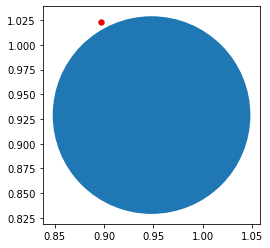

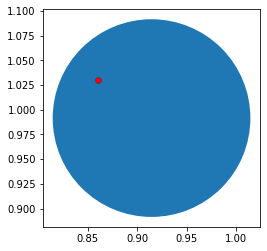

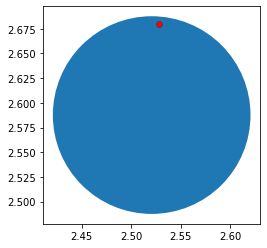

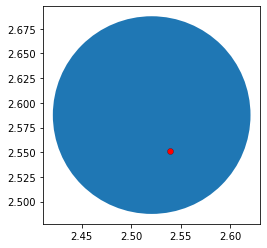

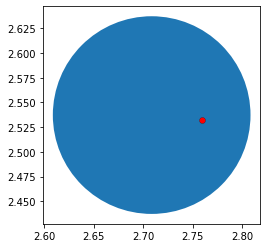

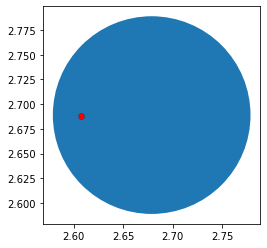

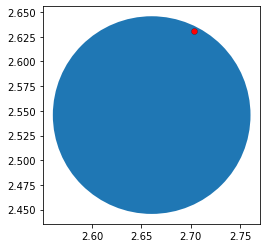

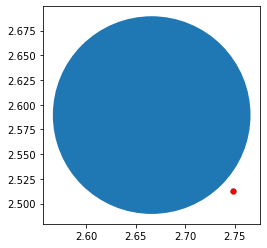

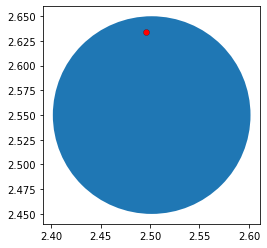

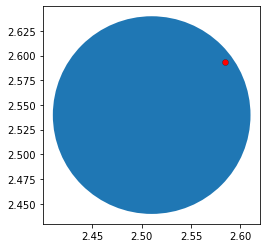

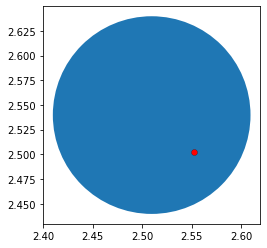

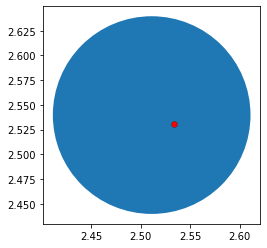

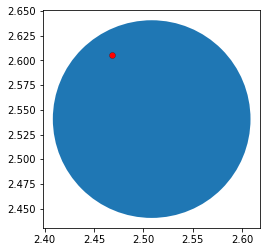

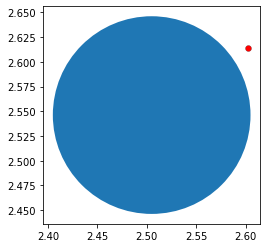

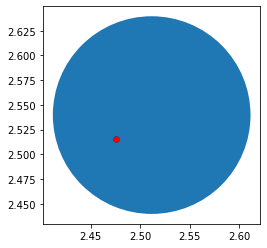

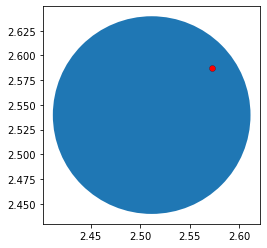

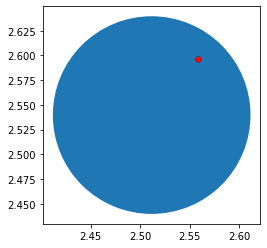

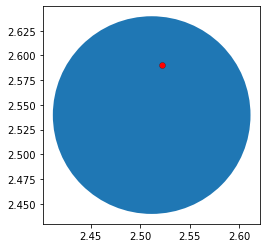

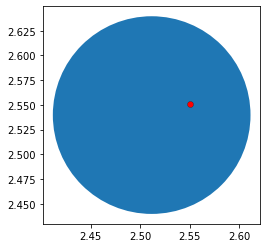

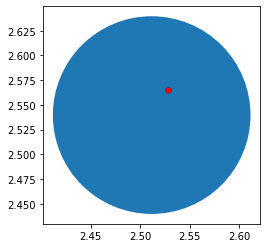

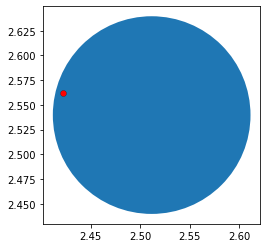

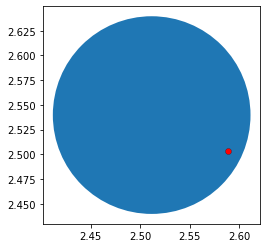

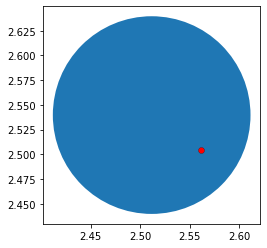

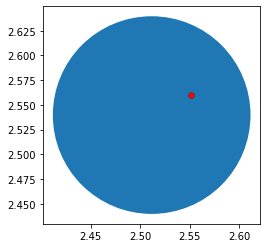

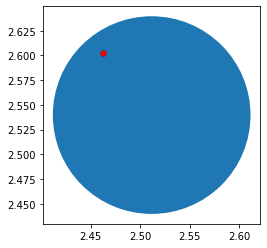

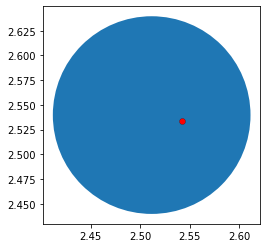

In [91]:
# create the problem instance
##mountain_boundary = [[0, 3], [0, 3]]
##hiking_problem = ContinuousProblem(search_space=mountain_boundary, \
##                                   objective_function=get_elevation)

# setup random state
seed = 3
random_state = get_random_state(seed)

p_start = Point(1, 0)
start_solution = Solution(p_start)
hiking_problem.evaluate(start_solution)

#create a Genetic Algorithm instance
ga1 = GeneticAlgorithm(problem_instance=hiking_problem,
                          random_state=random_state,
                          initial_solution=start_solution,
                          population_size = 20,
                          selection = tournament_selection,
                          crossover = geometrical_crossover,
                          crossover_probability = 0.8,
                          mutation = ball_mutation,
                          mutation_probability = 0.1,
                          survival = select_best_from_parents_and_children
                          )

max_stepsize_for_ballmutation = 0.1

# Optimize
ga_solutions1 = ga1.search(n_iterations = 20, \
                         max_stepsize = max_stepsize_for_ballmutation)

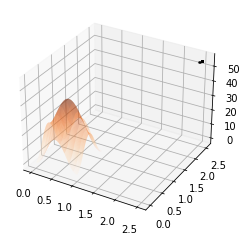

In [92]:
fig = plt.figure()
ax = plot_mountain(fig, X, Y)
for i in range(len(ga_solutions1)):
  ax = plot_position(ax, ga_solutions1[i].representation, color='black', size=5)
# show the plots
plt.show()